<a href="https://colab.research.google.com/github/rubensuarez22/Project2-ML/blob/main/ProjectML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier

# 1. Data Collection and Understanding

### Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/rubensuarez22/Project2-ML/refs/heads/main/dataset_with_commas.csv'
df = pd.read_csv(url)
df.head()

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches
0,Boston,19/2/2018 07:00,2 mins,False,True,1415,3245,256,34458.41163,3372,1476
1,Boston,19/2/2018 09:40,5 mins,True,False,1461,2363,203,29764.34982,2288,1275
2,Boston,19/2/2018 12:20,2 mins,False,False,1362,2184,118,27437.36736,2283,962
3,Boston,19/2/2018 15:00,5 mins,True,True,1984,3584,355,44995.45299,4035,2021
4,Boston,19/2/2018 17:40,2 mins,False,False,1371,2580,181,27583.95530,2200,979


#2. Data Preprocessing

###Initial data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city_id               126 non-null    object 
 1   period_start          126 non-null    object 
 2   wait_time             126 non-null    object 
 3   treat                 126 non-null    bool   
 4   commute               126 non-null    bool   
 5   trips_pool            126 non-null    int64  
 6   trips_express         126 non-null    int64  
 7   rider_cancellations   126 non-null    int64  
 8   total_driver_payout   126 non-null    float64
 9   total_matches         126 non-null    int64  
 10  total_double_matches  126 non-null    int64  
dtypes: bool(2), float64(1), int64(5), object(3)
memory usage: 9.2+ KB


Here I extracted just the hour and minute because I considered that those were the only important information in this case, also to avoid categorical information.

In [ ]:
df['period_start'] = pd.to_datetime(df['period_start'])
df['hour'] = df['period_start'].dt.hour
df['minute'] = df['period_start'].dt.minute
df.head()

<ipython-input-145-628d4bce7937>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['period_start'] = pd.to_datetime(df['period_start'])


,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,hour,minute
0,Boston,2018-02-19 07:00:00,2 mins,False,True,1415,3245,256,34458.41163,3372,1476,7,0
1,Boston,2018-02-19 09:40:00,5 mins,True,False,1461,2363,203,29764.34982,2288,1275,9,40
2,Boston,2018-02-19 12:20:00,2 mins,False,False,1362,2184,118,27437.36736,2283,962,12,20
3,Boston,2018-02-19 15:00:00,5 mins,True,True,1984,3584,355,44995.45299,4035,2021,15,0
4,Boston,2018-02-19 17:40:00,2 mins,False,False,1371,2580,181,27583.95530,2200,979,17,40


### Handling missing values

In [ ]:
print(df.isnull().sum())

city_id                 0
period_start            0
wait_time               0
treat                   0
commute                 0
trips_pool              0
trips_express           0
rider_cancellations     0
total_driver_payout     0
total_matches           0
total_double_matches    0
hour                    0
minute                  0
dtype: int64


### Dropped unused columns, no need for data transformation since there are no categorical features

In [ ]:
df = df.drop(columns=['city_id', 'wait_time', 'period_start'])
df.head()

,treat,commute,trips_pool,trips_express,rider_cancellations,total_driver_payout,total_matches,total_double_matches,hour,minute
0,False,True,1415,3245,256,34458.41163,3372,1476,7,0
1,True,False,1461,2363,203,29764.34982,2288,1275,9,40
2,False,False,1362,2184,118,27437.36736,2283,962,12,20
3,True,True,1984,3584,355,44995.45299,4035,2021,15,0
4,False,False,1371,2580,181,27583.95530,2200,979,17,40


###Feature scaling

Here I scaled all the numerical values except for the hour and minute since I need them for future usage.

In [ ]:
# Selección de columnas numéricas (int y float)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Columnas numéricas seleccionadas para escalado:", numeric_cols)


Columnas numéricas seleccionadas para escalado: Index(['trips_pool', 'trips_express', 'rider_cancellations',
       'total_driver_payout', 'total_matches', 'total_double_matches'],
      dtype='object')


In [ ]:
min_max_scaler = MinMaxScaler()
df[numeric_cols] = min_max_scaler.fit_transform(df[numeric_cols])

print("Datos normalizados:")
print(df.head())


Datos normalizados:
   treat  commute  trips_pool  trips_express  rider_cancellations  \
0  False     True    0.438095       0.560125             0.619231   
1   True    False    0.469388       0.252701             0.415385   
2  False    False    0.402041       0.190310             0.088462   
3   True     True    0.825170       0.678285             1.000000   
4  False    False    0.408163       0.328337             0.330769   

   total_driver_payout  total_matches  total_double_matches  hour  minute  
0             0.525920       0.522095              0.371954     7       0  
1             0.368562       0.204858              0.272004     9      40  
2             0.290555       0.203395              0.116360    12      20  
3             0.879151       0.716125              0.642964    15       0  
4             0.295469       0.179104              0.124814    17      40  


#3. Exploratory Data Analysis

### Define Rush Hour Periods

Define a function to identify rush hours based on the provided time ranges.

In [ ]:
def is_rush_hour(hour, minute):
    # Morning rush hour: 7:00 to 9:40
    if (7 <= hour < 10) and (hour != 9 or minute <= 40):
        return 1
    # Afternoon rush hour: 15:00 to 17:40
    elif (15 <= hour < 18) and (hour != 17 or minute <= 40):
        return 1
    return 0

# Apply the function to determine rush hour
df['rush_hour'] = df.apply(lambda row: is_rush_hour(row['hour'], row['minute']), axis=1)



### Visualize Cancellations During Rush vs Non-Rush Hours

Calculate the average cancellation rate during rush and non-rush hours and visualize it using a bar plot.

<ipython-input-151-bfd415cfcf73>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rush_hour_cancellations.index, y=rush_hour_cancellations.values, palette='viridis')


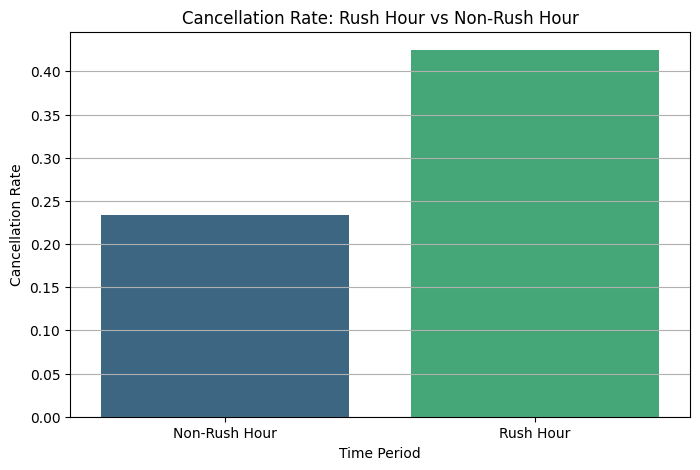

In [ ]:
# Calculate cancellation rate during rush and non-rush hours
rush_hour_cancellations = df.groupby('rush_hour')['rider_cancellations'].mean()

# Plot cancellation rate during rush and non-rush hours
plt.figure(figsize=(8, 5))
sns.barplot(x=rush_hour_cancellations.index, y=rush_hour_cancellations.values, palette='viridis')
plt.title('Cancellation Rate: Rush Hour vs Non-Rush Hour')
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])
plt.ylabel('Cancellation Rate')
plt.xlabel('Time Period')
plt.grid(axis='y')
plt.show()


### Visualize Numeric Feature Distributions

Generate histograms to analyze the distribution of variables like total_matches, total_double_matches, and rider_cancellations.

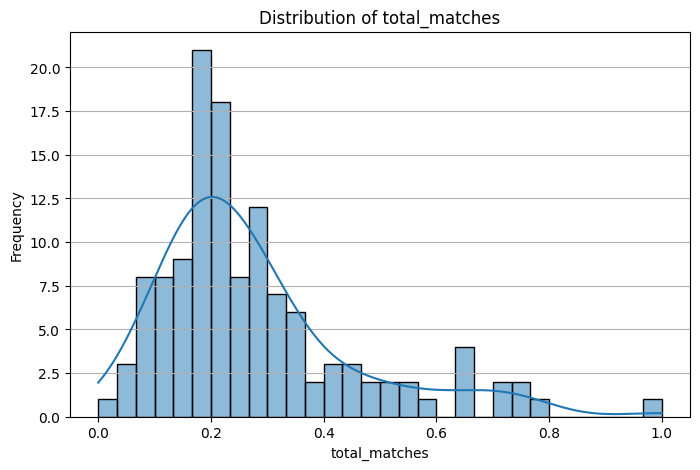

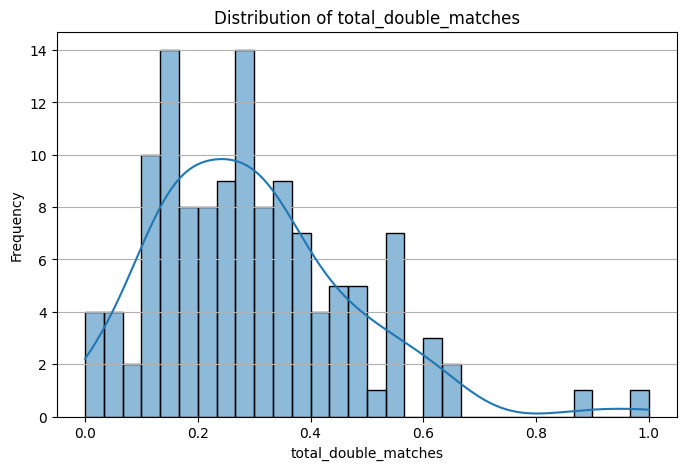

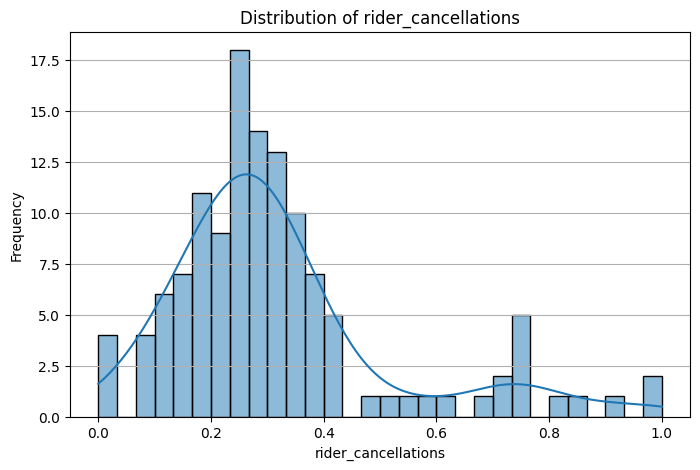

In [ ]:
# Visualize distributions of numeric features
numeric_features = ['total_matches', 'total_double_matches', 'rider_cancellations']

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()


### Correlation Heatmap

Calculate the correlation matrix for all numeric columns and visualize it using a heatmap.

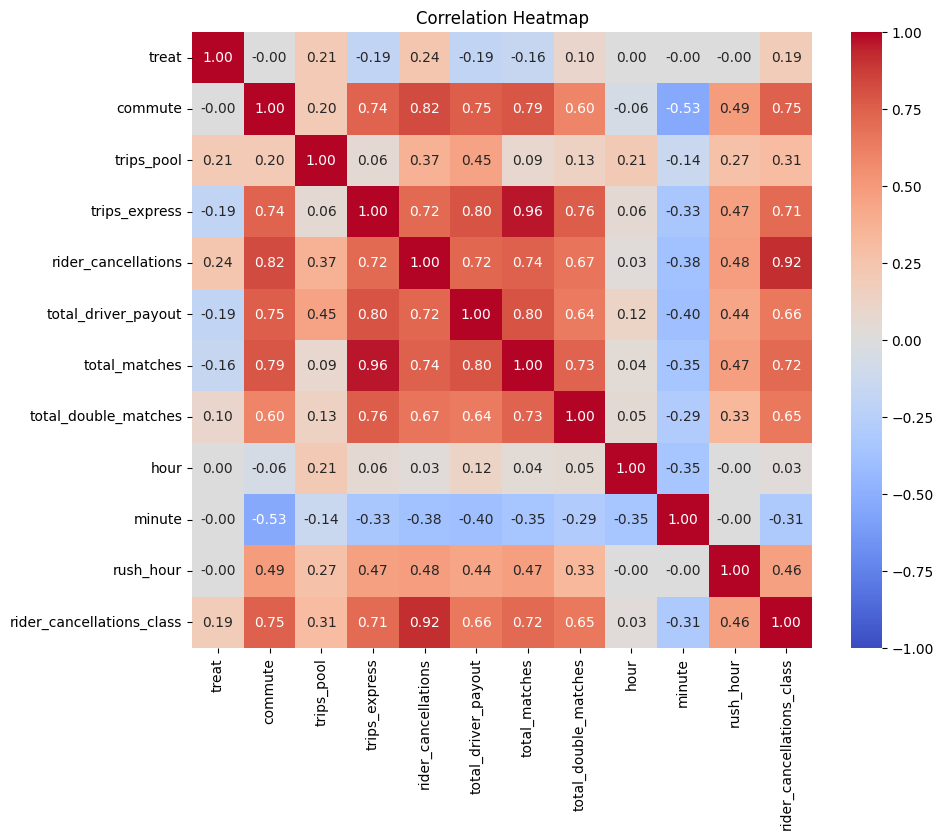

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


### Analyze Cancellation Rate by Hour of the Day

Examine how cancellation rates vary across hours of the day.

<ipython-input-127-739ebbde2d57>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_cancellations.index, y=hourly_cancellations.values, palette='coolwarm')


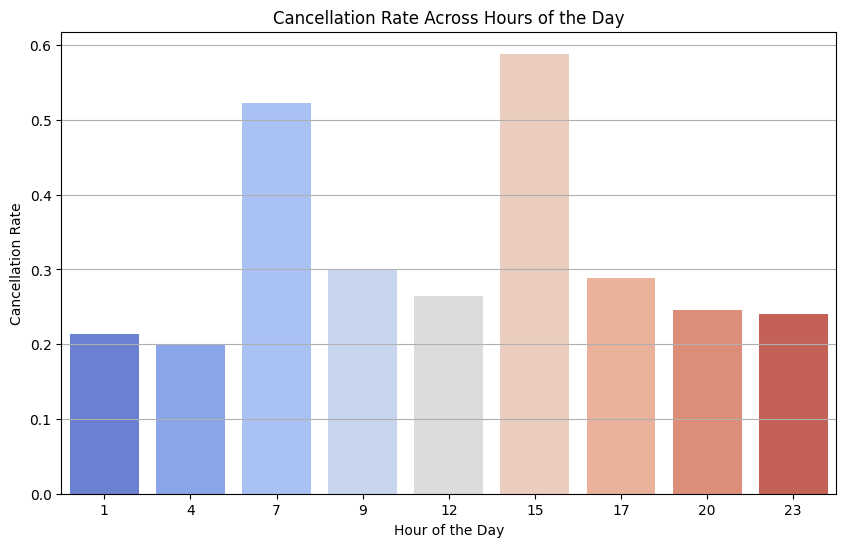

In [ ]:
# Cancellation rate by hour of the day
hourly_cancellations = df.groupby('hour')['rider_cancellations'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_cancellations.index, y=hourly_cancellations.values, palette='coolwarm')
plt.title('Cancellation Rate Across Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Cancellation Rate')
plt.grid(axis='y')
plt.show()


# 4. Model Building

Because I need to use the target value as categorical for either baseline regression model I did the following

In [ ]:
# Step 2: Define thresholds (bins) for scaled values
bins = [0, 0.25, 0.5, 0.75, 1.0]  # Divide into quartiles
labels = [0, 1, 2, 3]  # 0: Low, 1: Medium, 2: High, 3: Very High cancellations

# Categorize the target variable
df['rider_cancellations_class'] = pd.cut(df['rider_cancellations'], bins=bins, labels=labels, include_lowest=True)

# Check distribution
print(df['rider_cancellations_class'].value_counts())
print("Number of missing values after handling:", df['rider_cancellations'].isna().sum())

rider_cancellations_class
1    56
0    53
2    12
3     5
Name: count, dtype: int64
Number of missing values after handling: 0


###Split data

In [ ]:
features = ['commute', 'trips_express', 'total_driver_payout', 'total_matches', 'total_double_matches']
X = df[features]
y = df['rider_cancellations_class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Test the model

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions and Evaluation
print("Logistic Regression:")
y_pred_log = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_log, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

Logistic Regression:
Accuracy: 0.46153846153846156
Precision: 0.6076923076923078
Recall: 0.46153846153846156

Confusion Matrix:
 [[ 7  1  0]
 [13  2  0]
 [ 0  0  3]]


# 5. Ensemble Learning

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=250)
rf_model.fit(X_train, y_train)
y_pred_rfc = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Precision:", precision_score(y_test, y_pred_rfc, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rfc, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))

Accuracy: 0.5384615384615384
Precision: 0.6008606777837546
Recall: 0.5384615384615384

Confusion Matrix:
 [[5 3 0]
 [8 7 0]
 [0 1 2]]


In [ ]:
gbr_model = GradientBoostingClassifier(random_state=42, n_estimators=125, learning_rate=0.05, max_depth=3)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_gbr))
print("Precision:", precision_score(y_test, y_pred_gbr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gbr, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gbr))

Accuracy: 0.5
Precision: 0.5702662721893491
Recall: 0.5

Confusion Matrix:
 [[5 3 0]
 [8 7 0]
 [0 2 1]]


In [ ]:
# XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, n_estimators=300)
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the model
print("XGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Classifier:
Accuracy: 0.5
Precision: 0.5846153846153845
Recall: 0.5

Confusion Matrix:
 [[6 2 0]
 [9 6 0]
 [0 2 1]]


In [ ]:
# Initialize base classifiers
clf1 = DecisionTreeClassifier(random_state=42)
clf2 = LogisticRegression(random_state=42, max_iter=1000)
clf3 = KNeighborsClassifier(n_neighbors=7)

# Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[('dt', clf1), ('lr', clf2), ('knn', clf3)],
    voting='hard'
)

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Predictions
y_pred_vot = voting_clf.predict(X_test)

# Evaluate
print("Voting Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_vot))
print("Precision:", precision_score(y_test, y_pred_vot, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_vot, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_vot))

Voting Classifier:
Accuracy: 0.5384615384615384
Precision: 0.8153846153846154
Recall: 0.5384615384615384

Confusion Matrix:
 [[ 8  0  0]
 [12  3  0]
 [ 0  0  3]]


# 6. Model Optimization

## Hyperparameter Tuning

### Grid Search for Random Forest Classifier

In [ ]:
# Random Forest for Grid Search
rf_model_gs = RandomForestClassifier(random_state=42)

# Define parameter grid for Random Forest (Grid Search)
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 300]  # Number of trees
}

# Grid Search
grid_search_rf = GridSearchCV(estimator=rf_model_gs, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best Random Forest Model from Grid Search
best_rf_model_gs = grid_search_rf.best_estimator_
y_pred_rf_gs = best_rf_model_gs.predict(X_test)

# Evaluate the Grid Search model
print("Grid Search Random Forest Classifier")
print("Best Parameters:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_gs))
print("Precision:", precision_score(y_test, y_pred_rf_gs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf_gs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_gs))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid Search Random Forest Classifier
Best Parameters: {'n_estimators': 50}
Accuracy: 0.6153846153846154
Precision: 0.6631701631701632
Recall: 0.6153846153846154

Confusion Matrix:
 [[5 3 0]
 [7 8 0]
 [0 0 3]]


### Grid Search for Gradient Boosting

In [ ]:
# Gradient Boosting for Grid Search
gbr_model_gs = GradientBoostingClassifier(random_state=42, n_estimators=125)  # Fixed n_estimators

# Define parameter grid for Gradient Boosting (Grid Search)
param_grid_gbr = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]  # Learning rate values
}

# Grid Search
grid_search_gbr = GridSearchCV(estimator=gbr_model_gs, param_grid=param_grid_gbr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)

# Best Gradient Boosting Model from Grid Search
best_gbr_model_gs = grid_search_gbr.best_estimator_
y_pred_gbr_gs = best_gbr_model_gs.predict(X_test)

# Evaluate the Grid Search model
print("Grid Search Gradient Boosting Classifier")
print("Best Parameters:", grid_search_gbr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gbr_gs))
print("Precision:", precision_score(y_test, y_pred_gbr_gs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gbr_gs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gbr_gs))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Grid Search Gradient Boosting Classifier
Best Parameters: {'learning_rate': 0.2}
Accuracy: 0.46153846153846156
Precision: 0.5399600399600399
Recall: 0.46153846153846156

Confusion Matrix:
 [[5 3 0]
 [9 6 0]
 [0 2 1]]


### Grid Search for XGBoost

In [ ]:
# XGBoost for Grid Search
xgb_model_gs = XGBClassifier(random_state=42, n_estimators=125)  # Fix n_estimators

# Define parameter grid for XGBoost (Grid Search)
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]  # Learning rate values
}

# Grid Search
grid_search_xgb = GridSearchCV(estimator=xgb_model_gs, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best XGBoost Model from Grid Search
best_xgb_model_gs = grid_search_xgb.best_estimator_
y_pred_xgb_gs = best_xgb_model_gs.predict(X_test)

# Evaluate the Grid Search model
print("Grid Search XGBoost Classifier")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_gs))
print("Precision:", precision_score(y_test, y_pred_xgb_gs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb_gs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_gs))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Grid Search XGBoost Classifier
Best Parameters: {'learning_rate': 0.01}
Accuracy: 0.46153846153846156
Precision: 0.5247444862829478
Recall: 0.46153846153846156

Confusion Matrix:
 [[4 4 0]
 [9 6 0]
 [0 1 2]]


### Randomized Search for Random Forest

In [ ]:
# Random Forest for Randomized Search
rf_model_rs = RandomForestClassifier(random_state=42)

# Define parameter distribution for Randomized Search
param_dist_rf = {
    'n_estimators': randint(50, 300)  # Number of trees
}

# Randomized Search
random_search_rf = RandomizedSearchCV(
    estimator=rf_model_rs,
    param_distributions=param_dist_rf,
    n_iter=20,  # Number of combinations to try
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train)

# Best Random Forest Model from Randomized Search
best_rf_model_rs = random_search_rf.best_estimator_
y_pred_rf_rs = best_rf_model_rs.predict(X_test)

# Evaluate the Randomized Search model
print("\nRandomized Search Random Forest Classifier")
print("Best Parameters:", random_search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_rs))
print("Precision:", precision_score(y_test, y_pred_rf_rs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf_rs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_rs))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Randomized Search Random Forest Classifier
Best Parameters: {'n_estimators': 156}
Accuracy: 0.5
Precision: 0.5544871794871795
Recall: 0.5

Confusion Matrix:
 [[4 4 0]
 [8 7 0]
 [0 1 2]]


### Randomized Search for GradientBoosting

In [ ]:
# Gradient Boosting for Randomized Search
gbr_model_rs = GradientBoostingClassifier(random_state=42, n_estimators=125)  # Fixed n_estimators

# Define parameter distribution for Gradient Boosting (Randomized Search)
param_dist_gbr = {
    'learning_rate': uniform(0.01, 0.3)  # Learning rate range
}

# Randomized Search
random_search_gbr = RandomizedSearchCV(
    estimator=gbr_model_rs,
    param_distributions=param_dist_gbr,
    n_iter=20,  # Number of combinations to try
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search_gbr.fit(X_train, y_train)

# Best Gradient Boosting Model from Randomized Search
best_gbr_model_rs = random_search_gbr.best_estimator_
y_pred_gbr_rs = best_gbr_model_rs.predict(X_test)

# Evaluate the Randomized Search model
print("\nRandomized Search Gradient Boosting Classifier")
print("Best Parameters:", random_search_gbr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gbr_rs))
print("Precision:", precision_score(y_test, y_pred_gbr_rs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gbr_rs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gbr_rs))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Randomized Search Gradient Boosting Classifier
Best Parameters: {'learning_rate': 0.027425083650459835}
Accuracy: 0.5
Precision: 0.5702662721893491
Recall: 0.5

Confusion Matrix:
 [[5 3 0]
 [8 7 0]
 [0 2 1]]


### Randomized Search for XGBoost

In [ ]:
# XGBoost for Randomized Search
xgb_model_rs = XGBClassifier(random_state=42, use_label_encoder=False, n_estimators=125)  # Fix n_estimators

# Define parameter distribution for XGBoost (Randomized Search)
param_dist_xgb = {
    'learning_rate': uniform(0.01, 0.3)  # Learning rate range
}

# Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_rs,
    param_distributions=param_dist_xgb,
    n_iter=20,  # Number of combinations to try
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train)

# Best XGBoost Model from Randomized Search
best_xgb_model_rs = random_search_xgb.best_estimator_
y_pred_xgb_rs = best_xgb_model_rs.predict(X_test)

# Evaluate the Randomized Search model
print("\nRandomized Search XGBoost Classifier")
print("Best Parameters:", random_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_rs))
print("Precision:", precision_score(y_test, y_pred_xgb_rs, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb_rs, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_rs))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Randomized Search XGBoost Classifier
Best Parameters: {'learning_rate': 0.12236203565420874}
Accuracy: 0.46153846153846156
Precision: 0.5399600399600399
Recall: 0.46153846153846156

Confusion Matrix:
 [[5 3 0]
 [9 6 0]
 [0 2 1]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:34:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Cross Validation

### Cross Validation Random Forest

In [ ]:
# Cross-Validation for Random Forest (Grid Search)
cv_scores_rf_gs = cross_val_score(best_rf_model_gs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nRandom Forest (Grid Search) Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_rf_gs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_rf_gs.std():.4f}")

# Cross-Validation for Random Forest (Randomized Search)
cv_scores_rf_rs = cross_val_score(best_rf_model_rs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nRandom Forest (Randomized Search) Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_rf_rs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_rf_rs.std():.4f}")



Random Forest (Grid Search) Cross-Validation Results:
Mean Accuracy: 0.6000
Standard Deviation: 0.0316

Random Forest (Randomized Search) Cross-Validation Results:
Mean Accuracy: 0.5900
Standard Deviation: 0.0583


### Cross Validation Gradient Boosting

In [ ]:
# Cross-Validation for Gradient Boosting (Grid Search)
cv_scores_gbr_gs = cross_val_score(best_gbr_model_gs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nGradient Boosting (Grid Search) Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_gbr_gs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_gbr_gs.std():.4f}")

# Cross-Validation for Gradient Boosting (Randomized Search)
cv_scores_gbr_rs = cross_val_score(best_gbr_model_rs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nGradient Boosting (Randomized Search) Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_gbr_rs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_gbr_rs.std():.4f}")



Gradient Boosting (Grid Search) Cross-Validation Results:
Mean Accuracy: 0.5500
Standard Deviation: 0.1049

Gradient Boosting (Randomized Search) Cross-Validation Results:
Mean Accuracy: 0.5800
Standard Deviation: 0.1503


### Cross-Validation for XGBoost Models

In [ ]:
# Cross-Validation for Grid Search XGBoost Model
cv_scores_xgb_gs = cross_val_score(best_xgb_model_gs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nGrid Search XGBoost Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_xgb_gs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_xgb_gs.std():.4f}")

# Cross-Validation for Randomized Search XGBoost Model
cv_scores_xgb_rs = cross_val_score(best_xgb_model_rs, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("\nRandomized Search XGBoost Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_xgb_rs.mean():.4f}")
print(f"Standard Deviation: {cv_scores_xgb_rs.std():.4f}")



Grid Search XGBoost Cross-Validation Results:
Mean Accuracy: 0.5500
Standard Deviation: 0.1000

Randomized Search XGBoost Cross-Validation Results:
Mean Accuracy: 0.5400
Standard Deviation: 0.1356


# 7. Model Evaluation

## Evaluate Models with Performance Metrics

In [ ]:
# Function to evaluate a model
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"\n{name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return accuracy, precision, recall, confusion_matrix(y_test, y_pred)

# Evaluate each model
results = []
models = [
    ("Random Forest (Grid Search)", best_rf_model_gs),
    ("Random Forest (Randomized Search)", best_rf_model_rs),
    ("Gradient Boosting (Grid Search)", best_gbr_model_gs),
    ("Gradient Boosting (Randomized Search)", best_gbr_model_rs),
    ("XGBoost (Grid Search)", best_xgb_model_gs),
    ("XGBoost (Randomized Search)", best_xgb_model_rs)
]

for name, model in models:
    accuracy, precision, recall, cm = evaluate_model(name, model, X_test, y_test)
    results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "Confusion Matrix": cm})



Random Forest (Grid Search) Performance Metrics:
Accuracy: 0.6154
Precision: 0.6632
Recall: 0.6154

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.62      0.50         8
           1       0.73      0.53      0.62        15
           2       1.00      1.00      1.00         3

    accuracy                           0.62        26
   macro avg       0.71      0.72      0.71        26
weighted avg       0.66      0.62      0.62        26


Random Forest (Randomized Search) Performance Metrics:
Accuracy: 0.5000
Precision: 0.5545
Recall: 0.5000

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.58      0.47      0.52        15
           2       1.00      0.67      0.80         3

    accuracy                           0.50        26
   macro avg       0.64      0.54      0.57        26
weighted avg       0.55      0.50    

## Plot the Confusion Matrix to visualize model performance

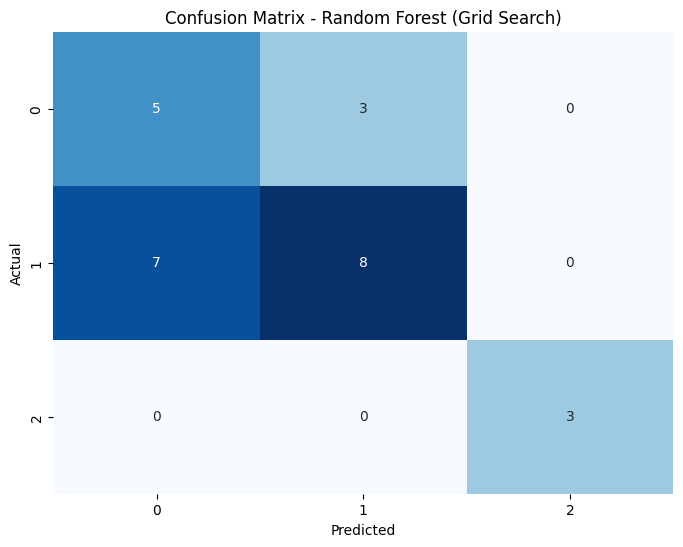

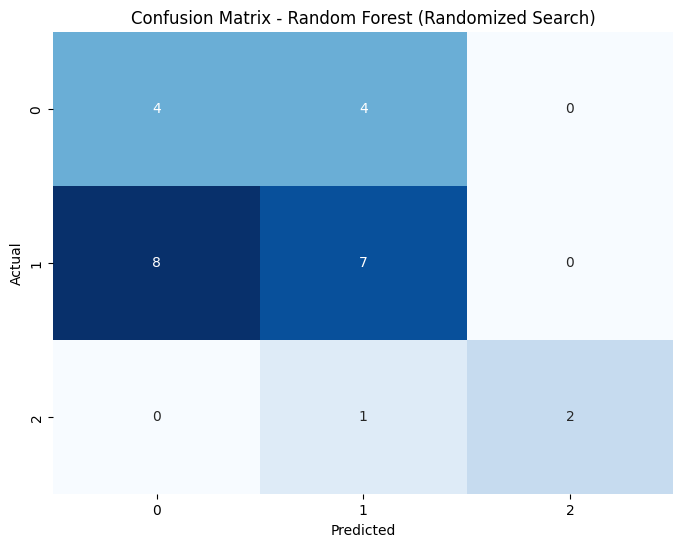

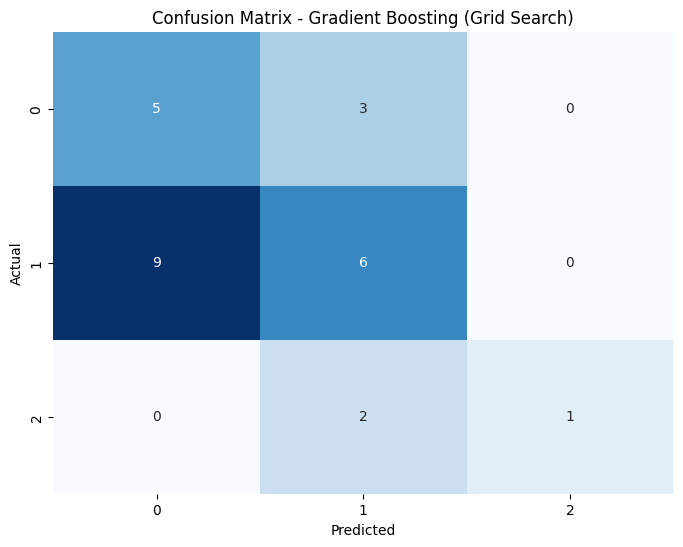

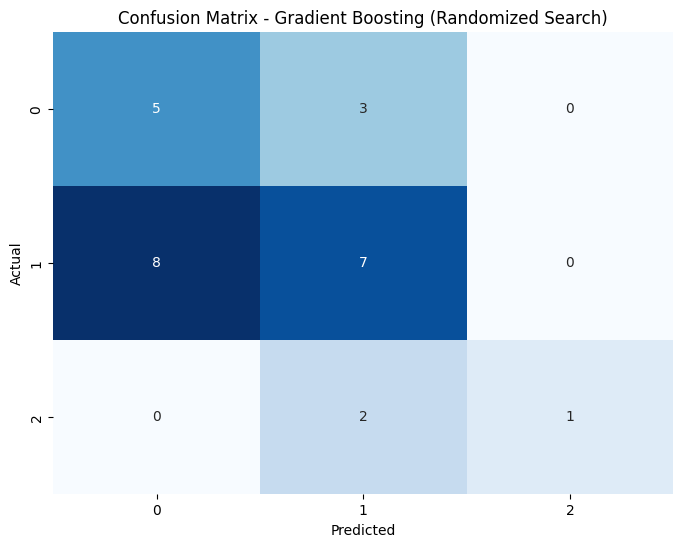

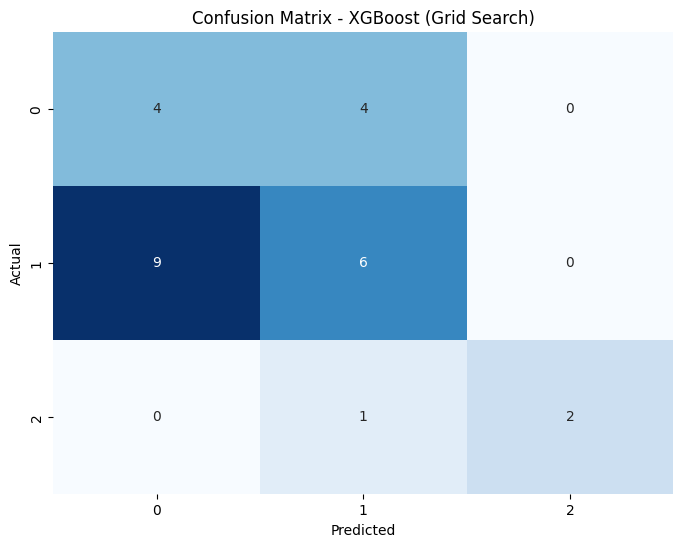

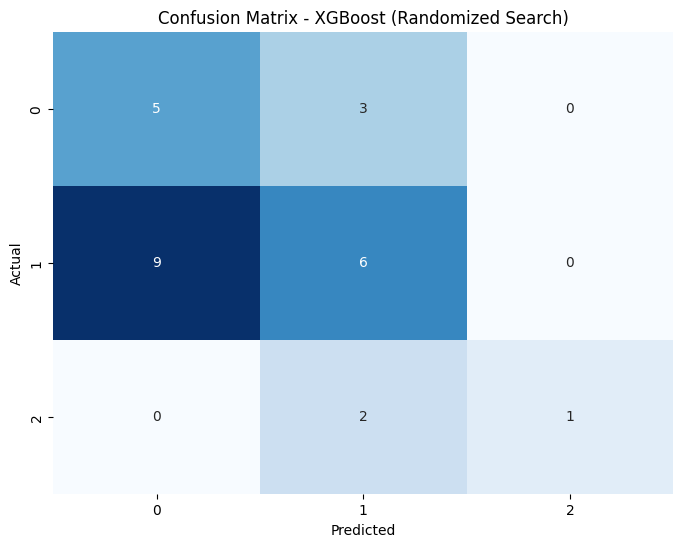

In [ ]:
# Function to plot a confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices for each model
for result in results:
    plot_confusion_matrix(result["Confusion Matrix"], result["Model"])


## Compare Performance Across Models

In [ ]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame(results).drop("Confusion Matrix", axis=1)
comparison_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display the comparison table
print("\nModel Performance Comparison:")
print(comparison_df)



Model Performance Comparison:
                                   Model  Accuracy  Precision    Recall
0            Random Forest (Grid Search)  0.615385   0.663170  0.615385
1      Random Forest (Randomized Search)  0.500000   0.554487  0.500000
3  Gradient Boosting (Randomized Search)  0.500000   0.570266  0.500000
2        Gradient Boosting (Grid Search)  0.461538   0.539960  0.461538
4                  XGBoost (Grid Search)  0.461538   0.524744  0.461538
5            XGBoost (Randomized Search)  0.461538   0.539960  0.461538


# Feature Importance Analysis:

In [ ]:
# Function to extract and display feature importance
def get_feature_importance(model, feature_names, model_name):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    print(f"\nFeature Importance for {model_name}:")
    print(importance_df)
    return importance_df

# Feature names
feature_names = X_train.columns

# Get feature importance for each model
rf_gs_importance = get_feature_importance(best_rf_model_gs, feature_names, "Random Forest (Grid Search)")
rf_rs_importance = get_feature_importance(best_rf_model_rs, feature_names, "Random Forest (Randomized Search)")

gbr_gs_importance = get_feature_importance(best_gbr_model_gs, feature_names, "Gradient Boosting (Grid Search)")
gbr_rs_importance = get_feature_importance(best_gbr_model_rs, feature_names, "Gradient Boosting (Randomized Search)")

xgb_gs_importance = get_feature_importance(best_xgb_model_gs, feature_names, "XGBoost (Grid Search)")
xgb_rs_importance = get_feature_importance(best_xgb_model_rs, feature_names, "XGBoost (Randomized Search)")



Feature Importance for Random Forest (Grid Search):
                Feature  Importance
1         trips_express    0.255224
4  total_double_matches    0.221811
3         total_matches    0.217095
2   total_driver_payout    0.212862
0               commute    0.093007

Feature Importance for Random Forest (Randomized Search):
                Feature  Importance
1         trips_express    0.241390
3         total_matches    0.230774
4  total_double_matches    0.221343
2   total_driver_payout    0.218683
0               commute    0.087810

Feature Importance for Gradient Boosting (Grid Search):
                Feature  Importance
1         trips_express    0.267587
2   total_driver_payout    0.221478
4  total_double_matches    0.219064
3         total_matches    0.177369
0               commute    0.114501

Feature Importance for Gradient Boosting (Randomized Search):
                Feature  Importance
1         trips_express    0.246285
4  total_double_matches    0.231654
2   total_dr

## 9. Conclusion

Based on the results, the Random Forest model optimized using Grid Search demonstrated the best performance in terms of precision, recall, and accuracy. This can be attributed to the model's robustness to noise and its ability to effectively capture feature interactions through decision tree splits, even without explicitly defining them. These qualities enabled Random Forest to consistently outperform Gradient Boosting and XGBoost in this dataset.

When it comes to potential improvements it must be mentioned that the current dataset contains only 127 entries, which likely limits the model's ability to generalize. Expanding the dataset with more entries would enhance the reliability and robustness of all models.A more exhaustive effort to optimize the hyperparameters for Gradient Boosting and XGBoost via Grid Search or Randomized Search could lead to better performance. This includes exploring additional parameters. Finally, exploring stacking mechanisms, where several models (e.g., Random Forest, Gradient Boosting, XGBoost) are combined, could improve classification performance. This ensemble approach might leverage the strengths of each model to provide a more robust solution, similar to the concept of voting classifiers.